In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
def draw(epochs, losses, train_accs, test_accs):
    plt.plot([i for i in range(epochs)], losses, '-', color='#4169E1', alpha=0.8, linewidth=1, label="Loss Curve")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss Chart")
    plt.show()

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot([i for i in range(epochs)], train_accs, '-', color='blue', alpha=0.8, linewidth=1, label="Train Accuracy")
    plt.legend(loc="lower right")
    plt.plot([i for i in range(epochs)], test_accs, '-', color='red', alpha=0.8, linewidth=1, label="Test Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 105])
    plt.title("Accuracy Chart")
    plt.show()

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        out = self.relu(x)
        return out


class CNN(nn.Module):

    def __init__(self, n_channels, n_classes):
        super(CNN, self).__init__()
        self.conv1 = ConvBlock(n_channels, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3 = ConvBlock(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv5 = ConvBlock(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = ConvBlock(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool7 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv8 = ConvBlock(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv9 = ConvBlock(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool10 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv11 = ConvBlock(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv12 = ConvBlock(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool13 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.fc14 = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.pool10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.pool13(x)
        x = x.view(x.size(0), -1)
        out = self.fc14(x)
        return out

In [4]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [5]:
cuda_id = 0
device_name = "cuda:{}".format(cuda_id) if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

In [6]:
input_size = 3
num_classes = 10
model = CNN(input_size, num_classes)
model = model.to(device)
model

CNN(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (pool4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv5): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv6): ConvBlock(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, mome

In [7]:
epochs = 100
criterion = nn.CrossEntropyLoss()

In [8]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_loss += loss.item()
        total_correct += correct
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader), total_correct / (batch_size * len(train_loader)) * 100

In [9]:
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [10]:
def main(epochs, model, train_loader, test_loader, criterion, optimizer):
    losses = []
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        loss, train_acc = train(model, train_loader, criterion, optimizer)
        test_acc = test(model, test_loader)
        losses.append(loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f} %, Test Accuracy: {:.2f} %'
              .format(epoch + 1, epochs, loss, train_acc, test_acc))
    draw(epochs, losses, train_accs, test_accs)

Epoch [1/100], Loss: 1.1024, Train Accuracy: 60.72 %, Test Accuracy: 68.19 %
Epoch [2/100], Loss: 0.7094, Train Accuracy: 75.37 %, Test Accuracy: 75.43 %
Epoch [3/100], Loss: 0.5424, Train Accuracy: 81.18 %, Test Accuracy: 76.99 %
Epoch [4/100], Loss: 0.4251, Train Accuracy: 85.21 %, Test Accuracy: 78.43 %
Epoch [5/100], Loss: 0.3248, Train Accuracy: 88.70 %, Test Accuracy: 78.82 %
Epoch [6/100], Loss: 0.2510, Train Accuracy: 91.20 %, Test Accuracy: 78.31 %
Epoch [7/100], Loss: 0.1909, Train Accuracy: 93.26 %, Test Accuracy: 81.32 %
Epoch [8/100], Loss: 0.1454, Train Accuracy: 94.96 %, Test Accuracy: 82.10 %
Epoch [9/100], Loss: 0.1268, Train Accuracy: 95.56 %, Test Accuracy: 79.23 %
Epoch [10/100], Loss: 0.1072, Train Accuracy: 96.19 %, Test Accuracy: 81.41 %
Epoch [11/100], Loss: 0.0923, Train Accuracy: 96.73 %, Test Accuracy: 80.63 %
Epoch [12/100], Loss: 0.0847, Train Accuracy: 97.03 %, Test Accuracy: 81.93 %
Epoch [13/100], Loss: 0.0757, Train Accuracy: 97.31 %, Test Accuracy: 82.

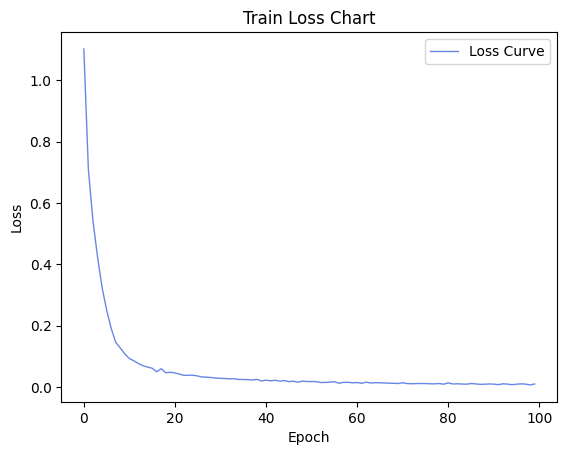

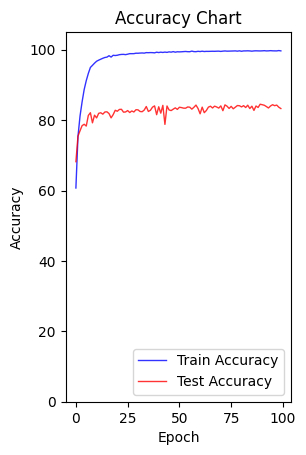

In [11]:
model = CNN(input_size, num_classes)
model = model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
main(epochs, model, train_loader, test_loader, criterion, optimizer)

Epoch [1/100], Loss: 1.1033, Train Accuracy: 60.50 %, Test Accuracy: 62.44 %
Epoch [2/100], Loss: 0.7160, Train Accuracy: 74.79 %, Test Accuracy: 73.96 %
Epoch [3/100], Loss: 0.5476, Train Accuracy: 81.06 %, Test Accuracy: 62.78 %
Epoch [4/100], Loss: 0.4200, Train Accuracy: 85.18 %, Test Accuracy: 77.20 %
Epoch [5/100], Loss: 0.3216, Train Accuracy: 88.79 %, Test Accuracy: 78.71 %
Epoch [6/100], Loss: 0.2487, Train Accuracy: 91.25 %, Test Accuracy: 73.06 %
Epoch [7/100], Loss: 0.1906, Train Accuracy: 93.23 %, Test Accuracy: 80.08 %
Epoch [8/100], Loss: 0.1556, Train Accuracy: 94.43 %, Test Accuracy: 81.42 %
Epoch [9/100], Loss: 0.1306, Train Accuracy: 95.41 %, Test Accuracy: 80.00 %
Epoch [10/100], Loss: 0.1111, Train Accuracy: 96.16 %, Test Accuracy: 80.59 %
Epoch [11/100], Loss: 0.0967, Train Accuracy: 96.59 %, Test Accuracy: 80.51 %
Epoch [12/100], Loss: 0.0873, Train Accuracy: 96.97 %, Test Accuracy: 81.80 %
Epoch [13/100], Loss: 0.0773, Train Accuracy: 97.22 %, Test Accuracy: 82.

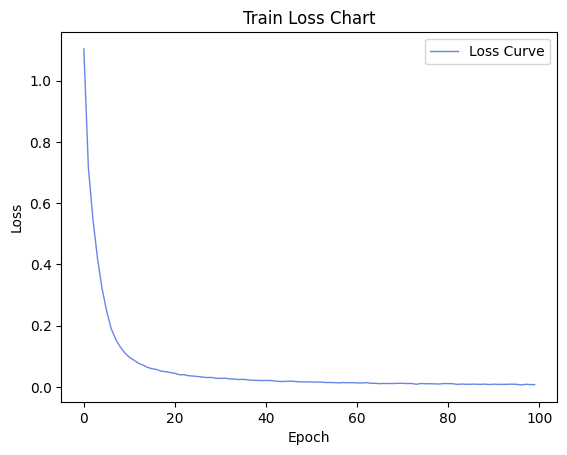

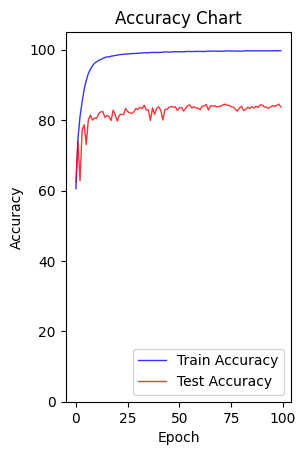

In [12]:
model = CNN(input_size, num_classes)
model = model.to(device)
lr = 1e-4
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
main(epochs, model, train_loader, test_loader, criterion, optimizer)

Epoch [1/100], Loss: 1.3277, Train Accuracy: 52.89 %, Test Accuracy: 60.09 %
Epoch [2/100], Loss: 1.0508, Train Accuracy: 63.55 %, Test Accuracy: 63.47 %
Epoch [3/100], Loss: 0.9426, Train Accuracy: 67.78 %, Test Accuracy: 65.10 %
Epoch [4/100], Loss: 0.8685, Train Accuracy: 70.55 %, Test Accuracy: 65.98 %
Epoch [5/100], Loss: 0.8148, Train Accuracy: 72.41 %, Test Accuracy: 66.51 %
Epoch [6/100], Loss: 0.7697, Train Accuracy: 74.32 %, Test Accuracy: 67.02 %
Epoch [7/100], Loss: 0.7293, Train Accuracy: 75.90 %, Test Accuracy: 67.62 %
Epoch [8/100], Loss: 0.6937, Train Accuracy: 77.24 %, Test Accuracy: 67.86 %
Epoch [9/100], Loss: 0.6654, Train Accuracy: 78.48 %, Test Accuracy: 67.99 %
Epoch [10/100], Loss: 0.6368, Train Accuracy: 79.58 %, Test Accuracy: 68.47 %
Epoch [11/100], Loss: 0.6082, Train Accuracy: 80.50 %, Test Accuracy: 68.68 %
Epoch [12/100], Loss: 0.5889, Train Accuracy: 81.31 %, Test Accuracy: 68.66 %
Epoch [13/100], Loss: 0.5622, Train Accuracy: 82.45 %, Test Accuracy: 68.

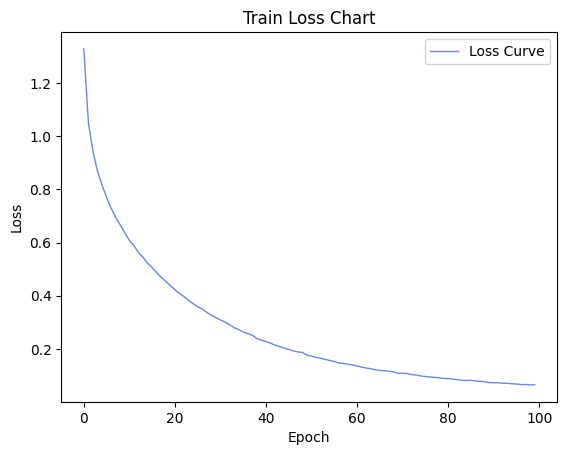

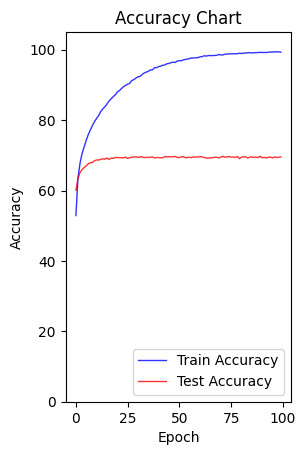

In [13]:
model = CNN(input_size, num_classes)
model = model.to(device)
lr = 1e-4
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
main(epochs, model, train_loader, test_loader, criterion, optimizer)

Epoch [1/100], Loss: 1.3272, Train Accuracy: 51.44 %, Test Accuracy: 63.73 %
Epoch [2/100], Loss: 0.8422, Train Accuracy: 70.90 %, Test Accuracy: 70.63 %
Epoch [3/100], Loss: 0.6610, Train Accuracy: 77.32 %, Test Accuracy: 77.28 %
Epoch [4/100], Loss: 0.5464, Train Accuracy: 81.43 %, Test Accuracy: 75.21 %
Epoch [5/100], Loss: 0.4453, Train Accuracy: 84.93 %, Test Accuracy: 81.48 %
Epoch [6/100], Loss: 0.3637, Train Accuracy: 87.71 %, Test Accuracy: 82.09 %
Epoch [7/100], Loss: 0.2935, Train Accuracy: 89.90 %, Test Accuracy: 82.65 %
Epoch [8/100], Loss: 0.2308, Train Accuracy: 92.05 %, Test Accuracy: 81.35 %
Epoch [9/100], Loss: 0.1877, Train Accuracy: 93.62 %, Test Accuracy: 83.35 %
Epoch [10/100], Loss: 0.1530, Train Accuracy: 94.81 %, Test Accuracy: 83.97 %
Epoch [11/100], Loss: 0.1250, Train Accuracy: 95.60 %, Test Accuracy: 83.34 %
Epoch [12/100], Loss: 0.1044, Train Accuracy: 96.37 %, Test Accuracy: 82.61 %
Epoch [13/100], Loss: 0.0920, Train Accuracy: 96.80 %, Test Accuracy: 83.

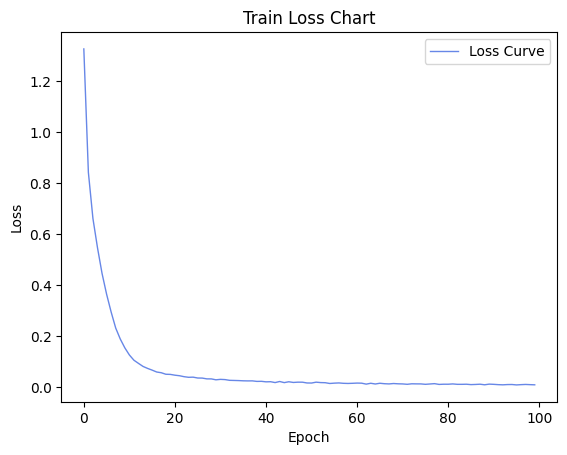

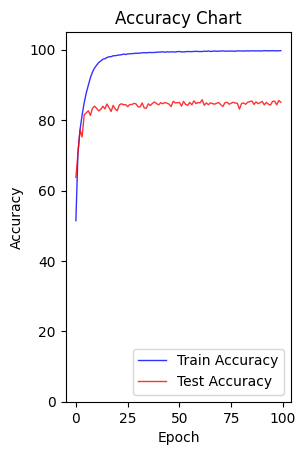

In [14]:
model = CNN(input_size, num_classes)
model = model.to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
main(epochs, model, train_loader, test_loader, criterion, optimizer)

Epoch [1/100], Loss: 1.3145, Train Accuracy: 53.26 %, Test Accuracy: 62.11 %
Epoch [2/100], Loss: 0.9334, Train Accuracy: 67.34 %, Test Accuracy: 67.07 %
Epoch [3/100], Loss: 0.7388, Train Accuracy: 74.37 %, Test Accuracy: 69.03 %
Epoch [4/100], Loss: 0.5696, Train Accuracy: 80.62 %, Test Accuracy: 68.66 %
Epoch [5/100], Loss: 0.4193, Train Accuracy: 86.28 %, Test Accuracy: 70.02 %
Epoch [6/100], Loss: 0.2895, Train Accuracy: 90.97 %, Test Accuracy: 69.61 %
Epoch [7/100], Loss: 0.1987, Train Accuracy: 94.08 %, Test Accuracy: 70.31 %
Epoch [8/100], Loss: 0.1422, Train Accuracy: 95.87 %, Test Accuracy: 70.14 %
Epoch [9/100], Loss: 0.1048, Train Accuracy: 97.06 %, Test Accuracy: 68.78 %
Epoch [10/100], Loss: 0.0879, Train Accuracy: 97.43 %, Test Accuracy: 69.26 %
Epoch [11/100], Loss: 0.0765, Train Accuracy: 97.70 %, Test Accuracy: 69.70 %
Epoch [12/100], Loss: 0.0645, Train Accuracy: 98.11 %, Test Accuracy: 70.03 %
Epoch [13/100], Loss: 0.0604, Train Accuracy: 98.08 %, Test Accuracy: 70.

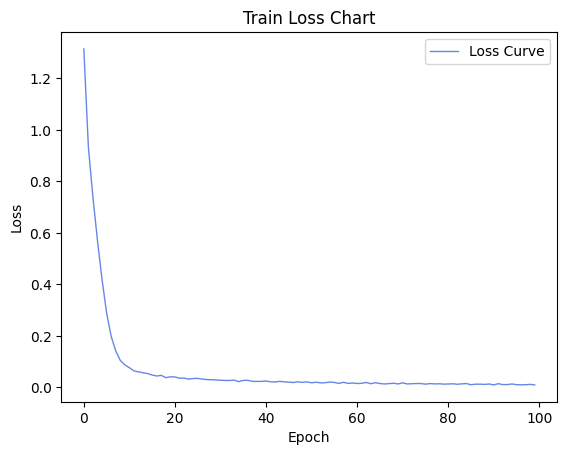

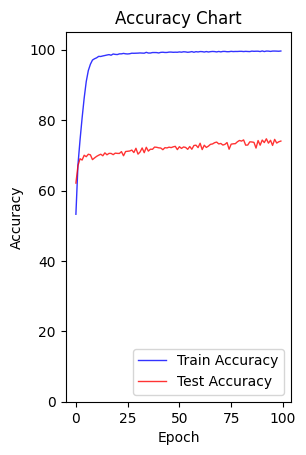

In [15]:
model = CNN(input_size, num_classes)
model = model.to(device)
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
main(epochs, model, train_loader, test_loader, criterion, optimizer)